### SUMMARY
- explore semantic annotations from RICO dataset
- set up Dataset and DataLoader
- control the resolution of the layout (all childrens/ only parents?)

### THOUGHT
- represent layout by class-tree, semantic segmentation, bboxes sequence

### CAVEAT
- align json and png pair
- construct layout image from bounding boxes parameters

In [5]:
import os
import json
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
img_dir = '/media/alex/Amazing/personal/Project/RICO_dataset/semantic_annotations'

In [10]:
all_jsons = glob.glob(f'{img_dir}/*.json')
all_pngs = glob.glob(f'{img_dir}/*.png')

len(all_jsons), len(all_pngs)

(66261, 66261)

### 1. Layout JSON, PNG Pair Sampler

In [15]:
class Sampler:
    def __init__(self, img_dir):
        self.img_dir = img_dir
        all_fns = os.listdir(img_dir)
        self.all_jsons = sorted([fn for fn in all_fns if fn.endswith('.json')])
        self.all_pngs = sorted([fn for fn in all_fns if fn.endswith('.png')])
        assert len(self.all_jsons) == len(self.all_pngs)
        
        self.idx = 0
    
    def sample(self):
        idx = random.sample(range(len(all_jsons)), 1)[0]
        return self.__getitem__(idx)
    
    def __len__(self):
        return len(self.all_jsons)
    
    def __getitem__(self, idx):
        if idx >= len(self.all_jsons):
            raise ValueError('all_jsons goes out of range')
        json_fn = os.path.join(self.img_dir, self.all_jsons[idx])
        png_fn = os.path.join(self.img_dir, self.all_pngs[idx])
        return json_fn, png_fn
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.idx >= len(self.all_jsons):
            self.idx = 0
            raise StopIteration
        json_fn, png_fn = self.__getitem__(self.idx)
        self.idx += 1
        return json_fn, png_fn

In [16]:
sampler = Sampler(img_dir)
len(sampler)

66261

In [18]:
json_fn, png_fn = sampler.sample()
json_fn, png_fn

('/media/alex/Amazing/personal/Project/RICO_dataset/semantic_annotations/62358.json',
 '/media/alex/Amazing/personal/Project/RICO_dataset/semantic_annotations/62358.png')

### 2. Represent One Layout

In [90]:
def read_json(fn):
    with open(fn, 'rb') as f:
        data = json.load(f)
    #print(f'opened: {fn}')
    return data

def resize_img(img, discount = 0.1):
    w, h = img.size
    resized_w = int(w * discount)
    resized_h = int(h * discount)
    resized_img = img.resize((resized_w, resized_h))
    return resized_img

class Layout:
    WIDTH = 1440
    HEIGHT = 2560
    
    def __init__(self, json_fn, png_fn, supress_img = True):
        self.json_fn = json_fn
        self.png_fn = png_fn
        
        self.json_tree = read_json(json_fn)
        classes, bboxs = self.parse_bboxs_from_json_tree()
        self.classes = classes
        self.bboxs = bboxs
        
        self.img = None if supress_img else resize_img(Image.open(png_fn))
        
    @property
    def rasterize_bboxs(self):
        im = Image.new('RGB', (self.WIDTH, self.HEIGHT), 
                       (255, 255, 255))
        draw = ImageDraw.Draw(im)
        for bbox in self.bboxs:
            draw.rectangle(bbox, outline = 255)
        rasterized_im = resize_img(im)
        return rasterized_im

    def __len__(self):
        return len(self.bboxs)
    
    
    def parse_bboxs_from_json_tree(self):
        layout_bboxs = []
        self._recursive_parse_json(
            self.json_tree, is_parse_parent = False, bboxs = layout_bboxs
        )

        if len(layout_bboxs) == 0:
            classes, bboxs = [], []
        else:
            classes, bboxs = zip(*layout_bboxs)
        return list(classes), list(bboxs)
    
    def _recursive_parse_json(self, json_tree, is_parse_parent = False, bboxs = []):
        if 'children' in json_tree:
            if is_parse_parent:
                child_bbox = json_tree['bounds']
                child_class = self.parse_classs(json_tree['class'])
                bboxs.append((child_class, child_bbox))

            child_nodes = json_tree['children']
            for child_node in child_nodes:
                self._recursive_parse_json(child_node, is_parse_parent, bboxs = bboxs)

        else:
            child_bbox = json_tree['bounds']
            child_class = self.parse_class(json_tree['class'])
            bboxs.append((child_class, child_bbox))
    
    @staticmethod
    def parse_class(class_name):
        return class_name.split('.')[-1]

In [91]:
sampler = Sampler(img_dir = img_dir)
json_fn, png_fn = sampler.sample()
json_fn, png_fn

('/media/alex/Amazing/personal/Project/RICO_dataset/semantic_annotations/14191.json',
 '/media/alex/Amazing/personal/Project/RICO_dataset/semantic_annotations/14191.png')

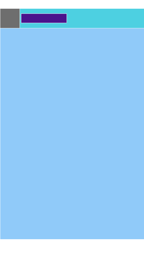

In [92]:
layout = Layout(json_fn, png_fn, supress_img = False)
layout.img

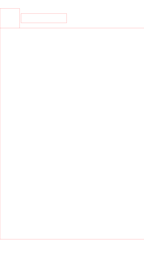

In [93]:
layout.rasterize_bboxs

In [100]:
layout.json_tree

{'ancestors': ['android.widget.FrameLayout',
  'android.view.ViewGroup',
  'android.view.View',
  'java.lang.Object'],
 'class': 'com.android.internal.policy.PhoneWindow$DecorView',
 'bounds': [0, 0, 1440, 2392],
 'clickable': False,
 'children': [{'iconClass': 'star',
   'ancestors': ['android.view.View', 'java.lang.Object'],
   'resource-id': 'com.ter.androidapp:id/menuButton',
   'clickable': True,
   'class': 'android.widget.ImageView',
   'bounds': [0, 84, 231, 263],
   'componentLabel': 'Icon'},
  {'ancestors': ['android.view.View', 'java.lang.Object'],
   'resource-id': 'com.ter.androidapp:id/infoTraficButton',
   'clickable': True,
   'class': 'android.widget.ImageView',
   'bounds': [1092, 84, 1440, 263],
   'componentLabel': 'Image'},
  {'ancestors': ['android.view.View', 'java.lang.Object'],
   'bounds': [0, 84, 980, 102],
   'clickable': False,
   'class': 'android.widget.ImageView',
   'componentLabel': 'Image'},
  {'text': 'Mes favoris',
   'ancestors': ['android.view.Vie

### 3. Distribution of # BBoxs 

In [79]:
bbox_n_ls = []
for json_fn, png_fn in sampler:
    layout = Layout(json_fn, png_fn)
    bbox_n = len(layout)
    bbox_n_ls.append(bbox_n)

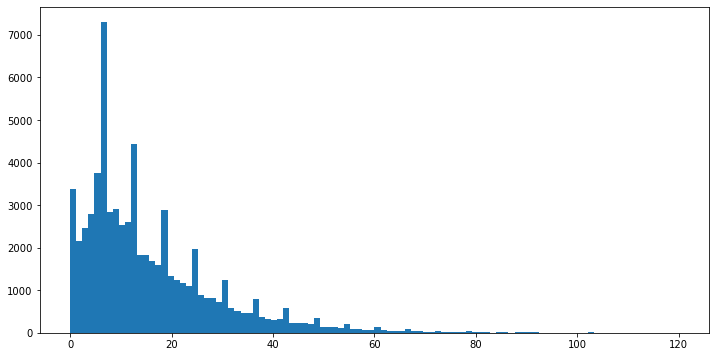

In [88]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.hist(bbox_n_ls, bins = 100, range = (0, 120));

In [82]:
max(bbox_n_ls), min(bbox_n_ls), np.mean(bbox_n_ls), np.std(bbox_n_ls)

(422, 0, 15.83817026606903, 14.251414530937371)

In [112]:
len([n for n in bbox_n_ls if n <= 30])

57698

### 4. Distribution of Classes

In [94]:
from collections import Counter
class_counter = Counter()

In [95]:
for json_fn, png_fn in sampler:
    layout = Layout(json_fn, png_fn)
    classes = layout.classes
    class_counter.update(classes)

In [96]:
len(class_counter)

5952

In [104]:
[_class for _class, cnt in class_counter.items() if cnt > 5000]

['o',
 'AppCompatTextView',
 'AppCompatImageView',
 'ImageButton',
 'ActionMenuItemView',
 'ImageView',
 'RelativeLayout',
 'TextView',
 'Button',
 'LinearLayout',
 'AppCompatImageButton',
 'AppCompatButton',
 'CustomFontTextView',
 'ActionMenuPresenter$OverflowMenuButton',
 'NavigationMenuItemView',
 'ab',
 'FontTextView',
 'CustomTextView',
 'RobotoTextView']